Round 1 | Feature: MajorAxisLength, Threshold: 422.2791, Polarity: -1, Error: 0.1356, Alpha: 0.9264
Round 2 | Feature: Perimeter, Threshold: 1006.3750, Polarity: -1, Error: 0.3602, Alpha: 0.2872
Round 3 | Feature: Perimeter, Threshold: 1259.4510, Polarity: -1, Error: 0.3894, Alpha: 0.2250
Round 4 | Feature: MajorAxisLength, Threshold: 423.8444, Polarity: 1, Error: 0.3882, Alpha: 0.2274
Round 5 | Feature: Perimeter, Threshold: 912.2590, Polarity: -1, Error: 0.4009, Alpha: 0.2008

Accuracy: 86.56%
Precision: 0.8364
Recall: 0.9089
F1 Score: 0.8711
ROC-AUC: 0.9216


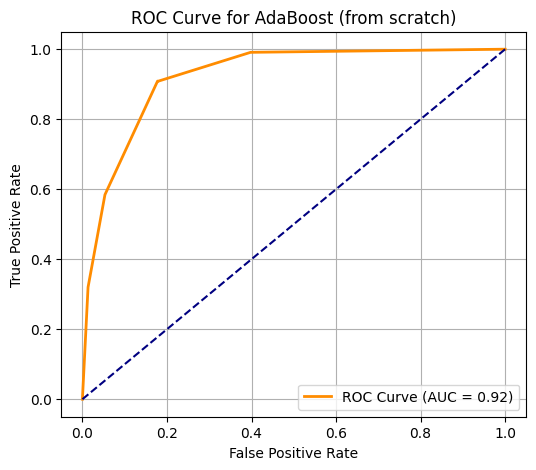

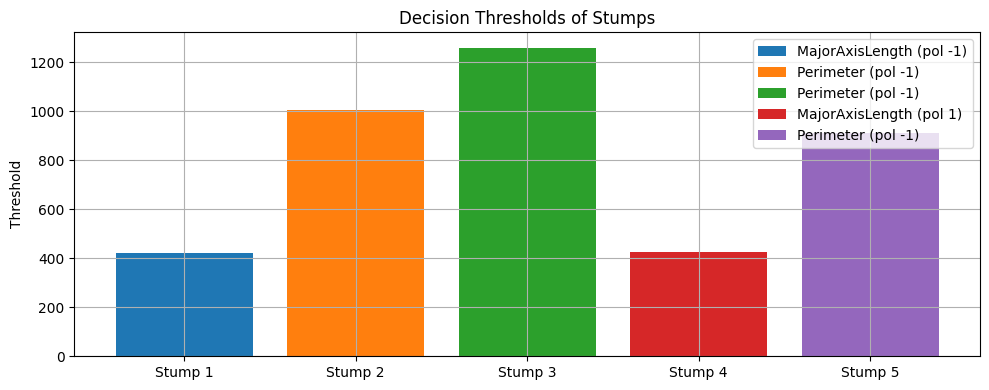

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# 1. Load the dataset
df = pd.read_excel("/content/Raisin_Dataset.xlsx")

# 2. Preprocess: Map class to binary labels
df['Label'] = df['Class'].map({'Kecimen': 1, 'Besni': -1})

# 3. Select features and labels
features = ['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
            'ConvexArea', 'Extent', 'Perimeter']
X = df[features].values
y = df['Label'].values
n_samples, n_features = X.shape

# 4. AdaBoost from scratch
T = 5
weights = np.ones(n_samples) / n_samples
alphas = []
stumps = []

def decision_stump(X, y, weights):
    n_samples, n_features = X.shape
    best_feature, best_threshold, best_polarity, min_error = None, None, None, float('inf')

    for feature_i in range(n_features):
        feature_values = X[:, feature_i]
        thresholds = np.unique(feature_values)

        for threshold in thresholds:
            for polarity in [1, -1]:
                predictions = np.ones(n_samples)
                predictions[polarity * feature_values < polarity * threshold] = -1
                misclassified = predictions != y
                error = np.sum(weights * misclassified)

                if error < min_error:
                    min_error = error
                    best_feature = feature_i
                    best_threshold = threshold
                    best_polarity = polarity

    return best_feature, best_threshold, best_polarity, min_error

# Training
for t in range(T):
    feature, threshold, polarity, error = decision_stump(X, y, weights)
    alpha = 0.5 * np.log((1 - error + 1e-10) / (error + 1e-10))

    preds = np.ones(n_samples)
    preds[polarity * X[:, feature] < polarity * threshold] = -1

    weights *= np.exp(-alpha * y * preds)
    weights /= np.sum(weights)

    alphas.append(alpha)
    stumps.append((feature, threshold, polarity))

    print(f"Round {t+1} | Feature: {features[feature]}, Threshold: {threshold:.4f}, Polarity: {polarity}, Error: {error:.4f}, Alpha: {alpha:.4f}")

# Prediction function
def strong_classifier(X):
    final_pred = np.zeros(X.shape[0])
    for alpha, (feature, threshold, polarity) in zip(alphas, stumps):
        pred = np.ones(X.shape[0])
        pred[polarity * X[:, feature] < polarity * threshold] = -1
        final_pred += alpha * pred
    return np.sign(final_pred), final_pred  # Return raw scores for ROC

# Predict
y_pred, y_scores = strong_classifier(X)

# Metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
roc_auc = roc_auc_score(y, y_scores)

# Print metrics
print(f"\nAccuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y, y_scores)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for AdaBoost (from scratch)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Optional: Plot Decision Thresholds per stump
plt.figure(figsize=(10, 4))
for i, (feature, threshold, polarity) in enumerate(stumps):
    plt.bar(i, threshold, label=f"{features[feature]} (pol {polarity})")
plt.ylabel("Threshold")
plt.xticks(range(T), [f"Stump {i+1}" for i in range(T)])
plt.title("Decision Thresholds of Stumps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
